# Bayesian SIR

Antonio Feltrin, Giosuè Sardo Infirri, Riccardo Tancredi, Simone Toso


## Scaletta
 - MCMC con un solo parametro

In [93]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist
from tqdm import tqdm

## Data generation

In [258]:
#Parameter initialization
N = int(1e6)
T = 101
I0 = 50

betas = 25*[0.3]+25*[.4]+25*[.25]+26*[.2]
gammas = 25*[0.05]+25*[.15]+25*[.2]+26*[.25]

#Simulation
initial_conf = np.array([N-I0, I0, 0])

configurations = np.zeros([T, 3])
configurations[0, :] = initial_conf

for tt in range(1, T):
    beta_true = betas[tt]
    gamma_true = gammas[tt]
    
    delta_I = npr.binomial(configurations[tt-1][0],
                           1 - np.exp(-beta_true*configurations[tt-1][1]/N))
    delta_R = npr.binomial(configurations[tt-1][1],
                           gamma_true)
    configurations[tt][0] = configurations[tt-1][0] - delta_I
    configurations[tt][1] = configurations[tt-1][1] + delta_I - delta_R
    configurations[tt][2] = configurations[tt-1][2] + delta_R

Text(0.5, 1.0, 'Simulated data with varying parameters')

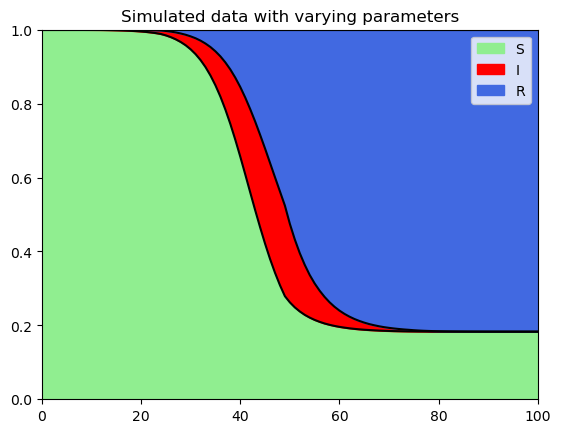

In [259]:
xs = np.arange(0, T)
ss = configurations[:, 0] / N
ii = configurations[:, 1]/N + ss
rr = configurations[:, 2]/N + ii

plt.plot(ss, c = "black")
plt.plot(ii, c = "black")
plt.plot(rr, c = "black")
plt.ylim([0, 1])

plt.fill_between(xs, 0, ss, label = "S", color = "lightgreen")
plt.fill_between(xs, ss, ii, label = "I", color = "red")
plt.fill_between(xs, ii, rr, label = "R", color = "royalblue")

plt.xlim([0, T-1])
plt.legend()
plt.title("Simulated data with varying parameters")

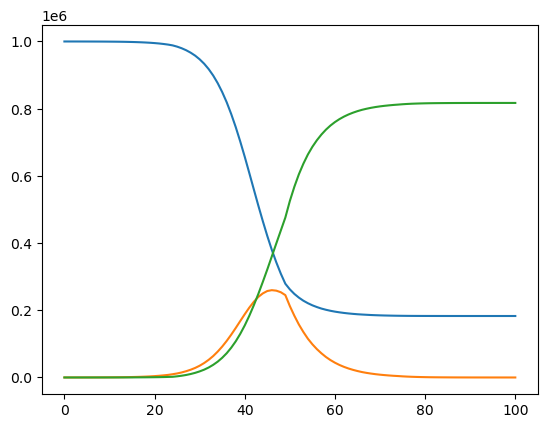

In [260]:
plt.plot(configurations[:, 0])
plt.plot(configurations[:, 1])
plt.plot(configurations[:, 2])

# MCMC functions definition


In [261]:
def mylog(x):
    try:
        x = np.array(x)
        mask = x > 0
        output = np.zeros(len(x))
        output[mask] = np.log(x[mask])
        output[~mask] = -1022
        return output
    except:
        return np.log(x) if x > 0 else -1022

### Delta update

In [262]:
def conditional_betagamma_old(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        indic = eta == ii
        total += 2*mylog(gammafunc(0.1 + np.sum(indic)))
        total -= mylog(0.1 + np.sum(beta*(indic)))*(0.1 + np.sum(indic))
        total -= mylog(0.1 - np.sum(mylog(gamma)*(indic)))*(0.1 + np.sum(indic))
    return total

def conditional_betagamma(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        indic = eta == ii
        total = total + 0.2*np.log(0.1) - 2*np.log(gammafunc(0.1))
        total = total + 2*mylog(gammafunc(0.1 + np.sum(indic))) - np.sum(indic*mylog(gamma))
        total = total - (0.1+np.sum(indic))*(mylog(.1 + np.sum(indic*beta)) + mylog(0.1 - np.sum(indic*mylog(gamma))))
    return total

def JJ(delta_proposed, delta_now, T):
    
    sum_proposed = np.sum(delta_proposed).astype(int)
    sum_now = np.sum(delta_now).astype(int)
    
    if sum_proposed == sum_now:
        return 1
    elif [sum_proposed, sum_now] == [1, 2] or [sum_proposed, sum_now] == [T, T-1]:
        return 3/(T-1)
    elif [sum_proposed, sum_now] == [2, 1] or [sum_proposed, sum_now] == [T-1, T]:
        return (T-1)/3
    elif sum_proposed < sum_now:
        return (sum_now - 1)/(T-sum_proposed)
    else:
        return (T- sum_now) / (sum_proposed - 1)
    
def update_delta(delta_proposed, delta_now, beta_now, gamma_now, p, T):
    #Step 1: evaluate first term pi/pi
    difference = np.sum(delta_proposed - delta_now)
    first_term = difference*mylog(p/(1-p))
    
    #Step 2: evaluate second term:
    second_term = conditional_betagamma(delta_proposed, beta_now, gamma_now)
    second_term -= conditional_betagamma(delta_now, beta_now, gamma_now)
    
    #Step 3: evaluate third term
    third_term = mylog(JJ(delta_proposed, delta_now, T))
    
    log_m = first_term + second_term + third_term
        
    probability = min(0, log_m)
    
        
    eps = np.log(npr.uniform()) 
   # print(f"eps {eps}")
    if eps < probability:
        return delta_proposed
    else:
        return delta_now
    
def propose_delta(delta_now, T):
    delta = delta_now.copy()
    K = np.sum(delta).astype(int)
    if K == 1:
        probs = np.array([1,0,0])
    elif K==T:
        probs = np.array([0,1,0])
    else:
        probs = np.array([1,1,1])/3
        
    choice = npr.choice([0,1,2], p = probs)
    
    if choice == 0: #add
        index = npr.choice(np.where(delta_now == 0)[0])
        delta[index] += 1
    elif choice == 1: #delete
        index = npr.choice(np.where(delta_now[1:] == 1)[0]) + 1
        delta[index] -= 1
    else: #swap
        candidates = np.where((delta_now[1:T-1] - delta_now[2:T]) != 0)[0] + 1
        index_0 = npr.choice(candidates)
        delta[index_0] = 1 - delta[index_0]
        delta[index_0+1] = 1 - delta[index_0+1]

    
    return delta  

### b and r update

In [263]:
def update_b(delta_now, beta_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    b_next = np.zeros(K)
    for kk in range(K):
        b_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1+np.sum(beta_now*(eta==kk))))
    return b_next

def update_r(delta_now, gamma_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    r_next = np.zeros(K)
    for kk in range(K):
        r_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1 + np.sum(-mylog(gamma_now)*(eta==kk))))

    return r_next

### Update beta and gamma

In [264]:
#For each beta find a sample from posterior
def update_beta(S, I, N, T, b): #cool beta distribution trick
    new_betas = np.zeros(T)
    for tt in range(T):
        C = I[tt]/N
        D = -S[tt+1]+S[tt]
        A = C*(S[tt]-D)+b[tt]
        y = npr.beta(a = A/C, b = D+1)
        new_betas[tt] = -1/C*np.log(y)
        
    return new_betas

def update_gamma(I, R, N, T, r):
    new_gammas = np.zeros(T)
    for tt in range(T):
        delta_R = R[tt+1]-R[tt]
        new_gammas[tt] = npr.beta(delta_R + r[tt], I[tt]-delta_R+1)
    return new_gammas

# Let's try a full run

In [266]:
n_steps = int(25000)

p = 0.1
T = 100

burnin = 5000
thin = 10

betas_run = np.zeros([T, n_steps])
gammas_run = np.zeros([T, n_steps])
bs_run = np.zeros([T, n_steps])
rs_run = np.zeros([T, n_steps])
deltas_run = np.zeros([T, n_steps])


# Initialize parameters
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()


for step in tqdm(range(n_steps), desc='Buffering...', colour='green'):
    if step%1000 == 0:
        print(step)
    
    delta_new = propose_delta(delta, T)
    delta = update_delta(delta_new, delta, beta, gamma, p, T)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    eta = np.cumsum(delta)
    b = b[eta-1]
    r = r[eta-1]
    
    beta = update_beta(configurations[:,0], configurations[:,1], N, T, b)
    gamma = update_gamma(configurations[:,1], configurations[:,2], N, T, r)
    
    if step >= burnin and step % 1 == 0:
        betas_run[:, step] = beta
        gammas_run[:,step] = gamma
        deltas_run[:,step] = delta
        bs_run[:,step] = b
        rs_run[:,step] = r
    
    

Buffering...:   0%|                        | 111/25000 [00:00<00:42, 584.62it/s]

0


Buffering...:   5%|█                      | 1200/25000 [00:01<00:24, 968.15it/s]

1000


Buffering...:   8%|█▊                    | 2112/25000 [00:02<00:22, 1026.49it/s]

2000


Buffering...:  13%|██▉                    | 3137/25000 [00:03<00:22, 981.15it/s]

3000


Buffering...:  17%|███▊                   | 4129/25000 [00:04<00:23, 902.20it/s]

4000


Buffering...:  21%|████▋                  | 5153/25000 [00:06<00:26, 756.16it/s]

5000


Buffering...:  25%|█████▋                 | 6140/25000 [00:07<00:21, 883.15it/s]

6000


Buffering...:  29%|██████▌                | 7133/25000 [00:08<00:21, 845.65it/s]

7000


Buffering...:  32%|███████▍               | 8114/25000 [00:09<00:22, 761.08it/s]

8000


Buffering...:  37%|████████▍              | 9154/25000 [00:11<00:20, 786.04it/s]

9000


Buffering...:  41%|████████▉             | 10139/25000 [00:12<00:16, 922.64it/s]

10000


Buffering...:  44%|█████████▊            | 11083/25000 [00:13<00:14, 967.44it/s]

11000


Buffering...:  49%|██████████▋           | 12190/25000 [00:14<00:12, 991.79it/s]

12000


Buffering...:  53%|███████████          | 13131/25000 [00:15<00:11, 1043.81it/s]

13000


Buffering...:  57%|███████████▉         | 14144/25000 [00:16<00:10, 1014.56it/s]

14000


Buffering...:  61%|████████████▋        | 15178/25000 [00:17<00:09, 1017.51it/s]

15000


Buffering...:  64%|█████████████▌       | 16105/25000 [00:18<00:08, 1000.78it/s]

16000


Buffering...:  69%|██████████████▍      | 17153/25000 [00:19<00:07, 1020.05it/s]

17000


Buffering...:  73%|███████████████▎     | 18189/25000 [00:20<00:06, 1004.86it/s]

18000


Buffering...:  76%|████████████████     | 19116/25000 [00:21<00:05, 1026.08it/s]

19000


Buffering...:  81%|████████████████▉    | 20157/25000 [00:22<00:04, 1016.19it/s]

20000


Buffering...:  85%|██████████████████▋   | 21180/25000 [00:23<00:03, 998.09it/s]

21000


Buffering...:  89%|███████████████████▌  | 22178/25000 [00:24<00:03, 927.65it/s]

22000


Buffering...:  93%|███████████████████▍ | 23179/25000 [00:25<00:01, 1010.70it/s]

23000


Buffering...:  96%|████████████████████▏| 24100/25000 [00:26<00:00, 1010.43it/s]

24000


Buffering...: 100%|██████████████████████| 25000/25000 [00:27<00:00, 920.58it/s]


## Bayesian estimators

In [267]:
#Keep column which are not empty

deltas_samples = deltas_run[:, burnin::thin]
bs_samples = bs_run[:, burnin::thin]
rs_samples = rs_run[:, burnin::thin]
betas_samples = betas_run[:, burnin::thin]
gammas_samples = gammas_run[:, burnin::thin]

In [268]:
#Every row is a timestep
beta_mean = np.mean(betas_samples, axis = 1)
beta_mean

array([0.25712151, 0.25809176, 0.36956553, 0.30818113, 0.33464728,
       0.30921573, 0.28576851, 0.26417296, 0.28252185, 0.3071299 ,
       0.28558332, 0.26655156, 0.30669137, 0.314637  , 0.31404545,
       0.3032851 , 0.3075196 , 0.30700596, 0.29174765, 0.30008115,
       0.29399387, 0.30404795, 0.2873763 , 0.31027499, 0.39015498,
       0.40563659, 0.40651975, 0.40249843, 0.39723944, 0.40449296,
       0.39988962, 0.40159881, 0.39964464, 0.4013967 , 0.39994238,
       0.39763283, 0.4003477 , 0.39881285, 0.40118603, 0.39951234,
       0.40226908, 0.40000265, 0.40008193, 0.3971129 , 0.40080225,
       0.40069384, 0.39823993, 0.40134789, 0.40008908, 0.2522031 ,
       0.25011748, 0.24643834, 0.25099134, 0.24449881, 0.25012535,
       0.24672991, 0.25613951, 0.24372283, 0.2484995 , 0.24796633,
       0.24421411, 0.25193982, 0.24955266, 0.24780974, 0.25944067,
       0.23446455, 0.2473432 , 0.27969822, 0.25599184, 0.25256037,
       0.2592593 , 0.22502093, 0.25486745, 0.24328114, 0.20076

In [270]:
beta = np.mean(betas_samples, axis = 1)
beta_mean.reshape(4, 25).mean(axis=1)

array([0.3023765 , 0.39476775, 0.24765752, 0.21158732])

In [271]:
gamma = np.mean(gammas_samples, axis = 1)
gamma.reshape(4, 25).mean(axis=1)
#plt.plot(gamma)

array([0.05677279, 0.15198276, 0.20259609, 0.24960018])

In [272]:
gamma

array([0.0950237 , 0.04909241, 0.08280846, 0.05432078, 0.0609886 ,
       0.03410831, 0.04312522, 0.04694993, 0.03598188, 0.05489098,
       0.04158396, 0.04236674, 0.06010523, 0.04371147, 0.05392586,
       0.05592665, 0.05504939, 0.0502893 , 0.05261016, 0.04581983,
       0.04771549, 0.05610556, 0.0596393 , 0.04906145, 0.14811917,
       0.15017846, 0.14837475, 0.15317017, 0.15055718, 0.15250074,
       0.14742003, 0.14950629, 0.15047015, 0.14865067, 0.14979526,
       0.14795462, 0.15048992, 0.14896223, 0.15029969, 0.15016289,
       0.15094927, 0.15055657, 0.14934373, 0.15012299, 0.14893371,
       0.15056194, 0.14948196, 0.14869934, 0.15113348, 0.20129286,
       0.19933104, 0.20153968, 0.20009789, 0.20258128, 0.19884885,
       0.19826907, 0.19982795, 0.2015509 , 0.20061151, 0.20007632,
       0.20014499, 0.20014616, 0.20081185, 0.19918993, 0.20345333,
       0.20373347, 0.19733265, 0.20435236, 0.20206062, 0.19908403,
       0.19848118, 0.19810859, 0.20719633, 0.19721344, 0.25085

In [273]:
deltas_run[:, (np.sum(deltas_run, axis = 0)) > 3]#[:, -2]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [274]:
deltas_samples#.shape

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 0., 1.]])

In [275]:
etas_samples = np.cumsum(deltas_samples, axis=0)

In [276]:
etas_samples

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 2., 1., ..., 2., 4., 1.],
       [1., 2., 1., ..., 2., 5., 1.],
       [2., 3., 2., ..., 2., 5., 2.]])

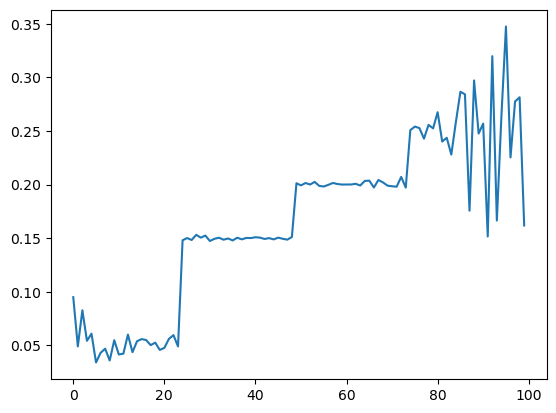

In [277]:
plt.plot(gamma)

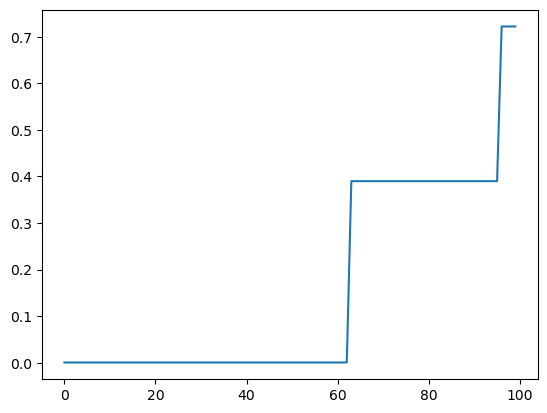

In [302]:
plt.plot(rs_samples[:,27])

In [292]:
rs_samples.shape

(100, 2000)

In [290]:
rs_samples[:,4]

array([0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.002226  , 0.002226  ,
       0.002226  , 0.002226  , 0.002226  , 0.37526095, 0.37526095,
       0.37526095, 0.37526095, 0.37526095, 0.37526095, 0.37526095,
       0.37526095, 0.37526095, 0.37526095, 0.37526095, 0.37526095,
       0.37526095, 0.37526095, 0.37526095, 0.37526095, 0.37526095,
       0.37526095, 0.37526095, 0.37526095, 0.37526095, 0.37526095,
       0.37526095, 0.37526095, 0.37526095, 0.37526095, 0.37526095,
       0.37526095, 0.37526095, 0.37526095, 0.37526095, 0.37526

### Veloce istogramma dei delta giusto per controllare che abbiano senso dove vengono messi

(array([2.017e+03, 7.000e+00, 9.000e+00, 1.500e+01, 2.000e+00, 1.500e+01,
        3.900e+01, 3.100e+01, 2.700e+01, 2.500e+01, 3.100e+01, 2.800e+01,
        3.600e+01, 4.900e+01, 9.100e+01, 7.900e+01, 6.600e+01, 3.100e+01,
        3.100e+01, 1.200e+01, 3.300e+01, 1.600e+01, 9.000e+00, 2.200e+01,
        8.000e+00, 1.400e+01, 1.500e+01, 8.400e+01, 2.970e+02, 1.648e+03]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ,
        36.3, 39.6, 42.9, 46.2, 49.5, 52.8, 56.1, 59.4, 62.7, 66. , 69.3,
        72.6, 75.9, 79.2, 82.5, 85.8, 89.1, 92.4, 95.7, 99. ]),
 <BarContainer object of 30 artists>)

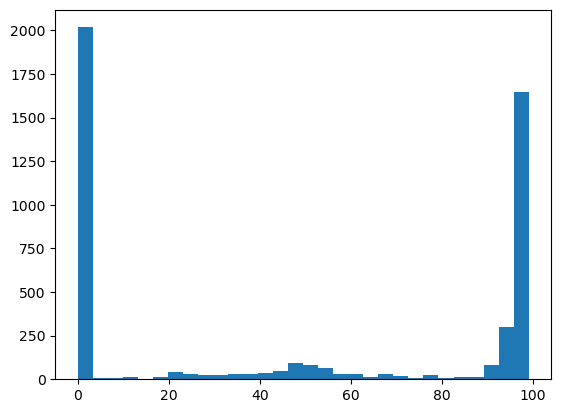

In [278]:
where = np.where(deltas_samples == 1)[0]
plt.hist(where, bins = 30)